## First, get the data into a useful format

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale = 1.5)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Read in datafiles
# gfs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/GFSDaily/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
gfs = pd.read_csv('./raw_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
# gfsfs = pd.read_csv('./raw_data/GFS_Sfc_42hrFcst_2010thru2019.csv', skiprows=1, index_col = 'Date', parse_dates = True)
# hourly = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly = pd.read_csv('./raw_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly.index = hourly.index + pd.DateOffset(hours=12)  # Align times

# obs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs = pd.read_csv('./raw_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs.index = obs.index + pd.DateOffset(hours=12)  # Align times

# sfc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/GFSSfc/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
sfc = pd.read_csv('./raw_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
sfc.index = sfc.index + pd.DateOffset(days=1)  # Align times
# prof = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project_4/GFSProfile/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
prof = pd.read_csv('./raw_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
prof.index = prof.index + pd.DateOffset(days=1)  # Align times

In [4]:
# There is some missing data from the GFS forecasts!
print(gfs.shape)
print(hourly.shape)
print(obs.shape)
print(sfc.shape)
print(prof.shape)

(3614, 4)
(3652, 7)
(3652, 4)
(3652, 15)
(3652, 60)


In [5]:
# Merge and drop all days with missing values 
features = pd.merge(obs.reset_index().dropna(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, prof.reset_index(), left_on = 'Date', right_on = 'index', how = 'inner').drop(columns = 'index')
features = pd.merge(features, sfc.reset_index(), left_on = 'Date', right_on = 'index', how = 'inner').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [6]:
features.describe()

,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,...,Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa)
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,...,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,17.588466,6.551807,7.599818,2.039245,16.145107,7.199022,5.772318,3.315404,13.900928,6.845879,...,46.387806,17.345102,1.130919,47.113278,36.469267,9.016094,69.911483,989.381213,986.438904,992.188765
std,11.899096,10.782862,2.932123,5.950638,11.201407,9.998378,2.349089,7.027440,11.958992,10.984311,...,42.981042,21.571487,7.485913,42.569690,30.263713,21.730328,37.603787,6.113929,6.585035,6.059707
min,-21.111111,-26.666667,2.235200,0.000000,-18.760000,-25.060000,1.431782,0.000000,-23.366667,-28.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,962.566667,954.800000,970.300000
25%,8.333333,-1.111111,5.811520,0.000000,7.140000,-0.560000,4.001250,0.000000,4.395833,-1.416667,...,0.000000,0.000000,0.000000,0.000000,7.888889,0.000000,41.000000,985.661111,982.800000,988.200000
50%,20.000000,7.777778,7.152640,0.000000,18.140000,8.440000,5.393515,0.310000,16.008333,7.400000,...,38.000000,7.666667,0.000000,46.000000,32.666667,0.000000,92.000000,989.166667,986.800000,991.600000
75%,27.777778,16.111111,9.387840,0.350000,25.940000,15.540000,7.170077,3.320000,24.445833,16.387500,...,96.000000,28.722222,0.000000,96.000000,60.000000,1.000000,100.000000,992.966667,990.450000,995.800000
max,37.777778,25.555556,23.246080,85.900000,37.140000,25.040000,16.413714,81.010000,34.716667,26.391667,...,101.000000,100.000000,100.000000,101.000000,100.000000,100.000000,101.000000,1012.800000,1010.400000,1016.400000


In [7]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [8]:
# The data we will be using to predict the labels
new_features = features.drop(columns = ['Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# Save feature list for later
feature_list = list(new_features.columns)

In [9]:
#feature_list

## Now run the model!

### Maximum Temperature

In [10]:
# Split the data into training and testing sets
train_features_tmax = np.array(new_features.query('year < 2019').drop(columns = ['Date']))
test_features_tmax  = np.array(new_features.query('year == 2019').drop(columns = ['Date']))
train_labels_tmax  = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_labels_tmax  = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])
test_dates = np.array(new_features.query('year == 2019')['Date']) # Dates

In [11]:
# Check if any NaNs exist
new_features.query('year < 2019').isna().sum()

Date             0
TMAX             0
TMIN             0
WMAX             0
RTOT             0
                ..
Min PRES(hPa)    0
Max PRES(hPa)    0
year             0
month            0
day              0
Length: 90, dtype: int64

In [12]:
# Check if any NaNs exist
features.query('year == 2019')['Max Hourly Temp (C)'].isna().sum()

0

In [13]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmax , new_features.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.51 degrees C.


In [14]:
print('Training Features Shape:', train_features_tmax .shape)
print('Training Labels Shape:', train_labels_tmax .shape)
print('Testing Features Shape:', test_features_tmax .shape)
print('Testing Labels Shape:', test_labels_tmax .shape)

Training Features Shape: (2924, 89)
Training Labels Shape: (2924,)
Testing Features Shape: (307, 89)
Testing Labels Shape: (307,)


In [15]:
# from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid

# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# from pprint import pprint
# pprint(random_grid)

In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
column_names_tmax  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

train_vars_tmax = new_features.query('year < 2019')[column_names_tmax] # Get the columns for training
test_vars_tmax = new_features.query('year == 2019')[column_names_tmax] # Get the columns for testing

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the model on training data
rfmax.fit(train_vars_tmax, train_labels_tmax);

#rf_random.best_params_
#n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, bootstrap = True

In [17]:
# Use the forest's predict method on the test data
#best_random = rf_random.best_estimator_
predictions_tmax = rfmax.predict(test_vars_tmax)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmax, predictions_tmax)), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


In [21]:
# Get numerical feature importances
importances = list(rfmax.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(column_names_tmax, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Max 925hPa TMPC      Importance: 0.25
Variable: Min 925hPa TMPC      Importance: 0.21
Variable: TMIN                 Importance: 0.15
Variable: TMAX                 Importance: 0.11
Variable: tmpc                 Importance: 0.09
Variable: Max 850hPa TMPC      Importance: 0.09
Variable: dwpc                 Importance: 0.04
Variable: Max DWPDEP(C)        Importance: 0.01
Variable: Avg LCLD(%)          Importance: 0.01
Variable: Avg PRES(hPa)        Importance: 0.01
Variable: Min 250hPa WSPD(m/s) Importance: 0.01
Variable: WMAX                 Importance: 0.0
Variable: day                  Importance: 0.0
Variable: Avg DWPDEP(C)        Importance: 0.0
Variable: Avg HCLD(%)          Importance: 0.0
Variable: Avg 850hPa DWPDEP(C) Importance: 0.0
Variable: Min 850hPa WSPD(m/s) Importance: 0.0


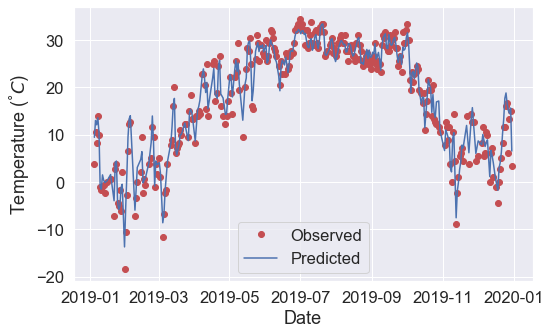

In [22]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_labels_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, predictions_tmax, 'b-', label = 'Predicted')
# ax.plot(predictions, 'b-')
# ax.plot(test_labels, 'ro')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.legend()
plt.tight_layout()
plt.savefig('./tmax_rf.png', dpi = 500)

### Minimum Temperature

In [23]:
# New labels, features remain the same
train_labels_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_labels_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

In [24]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmin, new_features.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.26 degrees C.


In [25]:
# Instantiate model with 1000 decision trees
rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
column_names_tmin = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 
train_vars_tmin = new_features.query('year < 2019')[column_names_tmin] # Get the columns for training
test_vars_tmin = new_features.query('year == 2019')[column_names_tmin] # Get the columns for testing

# Train the model on training data
rfmin.fit(train_vars_tmin, train_labels_tmin);

In [26]:
# Use the forest's predict method on the test data
predictions_tmin = rfmin.predict(test_vars_tmin)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_tmin, predictions_tmin)), 2), 'degrees C.') ##2.11C

Root Mean Square Error: 2.11 degrees C.


In [27]:
# Get numerical feature importances
importances = list(rfmin.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(column_names_tmin, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Min 925hPa TMPC      Importance: 0.22
Variable: tmpc                 Importance: 0.15
Variable: Min 850hPa TMPC      Importance: 0.14
Variable: TMIN                 Importance: 0.12
Variable: TMAX                 Importance: 0.09
Variable: dwpc                 Importance: 0.07
Variable: Avg 250hPa HGT(m)    Importance: 0.07
Variable: Avg 500hPa HGT(m)    Importance: 0.05
Variable: Max PRES(hPa)        Importance: 0.02
Variable: mslp                 Importance: 0.01
Variable: Avg PRES(hPa)        Importance: 0.01
Variable: Avg 850hPa DWPDEP(C) Importance: 0.01
Variable: Max 850hPa DWPDEP(C) Importance: 0.01
Variable: Min 250hPa WSPD(m/s) Importance: 0.01
Variable: WMAX                 Importance: 0.0
Variable: RTOT                 Importance: 0.0
Variable: wspd                 Importance: 0.0
Variable: skct                 Importance: 0.0
Variable: pr1h                 Importance: 0.0
Variable: Avg DWPDEP(C)        Importance: 0.0
Variable: Avg LCLD(%)          Importance: 0.0

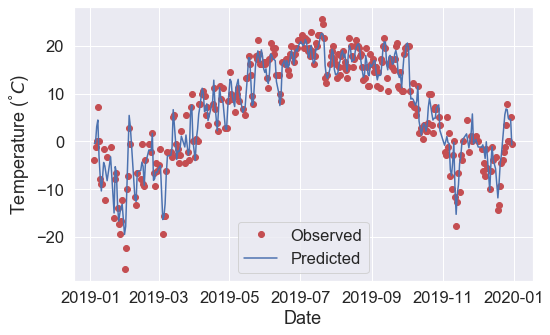

In [28]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_labels_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, predictions_tmin, 'b-', label = 'Predicted')
# ax.plot(predictions, 'b-')
# ax.plot(test_labels, 'ro')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.legend(loc = 'lower center')
plt.tight_layout()
plt.savefig('./tmin_rf.png', dpi = 500)

### Max Wind Speed

In [29]:
# New labels, features remain the same
train_labels_wmax = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_labels_wmax = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

In [30]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_wmax, new_features.query('year == 2019')['WMAX'].values)), 2), 'm/s.')

Root Mean Square Error: 3.32 m/s.


In [31]:
# Instantiate model with 1000 decision trees
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
# column_names_wmax = ['WMAX','tmpc','dwpc','wspd','mslp','skct','day','Min DWPDEP(C)','Avg LCLD(%)','Min LCLD(%)','Avg MCLD(%)','Max MCLD(%)','Avg PRES(hPa)','Min PRES(hPa)','Max PRES(hPa)',
#                      'Avg 250hPa HGT(m)','Min 850hPa TMPC','Max 850hPa TMPC','Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 500hPa WSPD(m/s)','Max 500hPa WSPD(m/s)',
#                      'Min 850hPa WSPD(m/s)','Max 850hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa TMPC',
#                      'Max 500hPa TMPC'] ## (using max_features='sqrt') RMSE = 1.71m/s
# train_vars_wmax = new_features.query('year < 2019')[column_names_wmax] # Get the columns for training
# test_vars_wmax = new_features.query('year == 2019')[column_names_wmax] # Get the columns for testing
train_vars_wmax = new_features.query('year < 2019').drop(columns = ['Date']).to_numpy()
test_vars_wmax = new_features.query('year == 2019').drop(columns = ['Date']).to_numpy()

# Train the model on training data
rfwind.fit(train_vars_wmax, train_labels_wmax)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=1600, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [32]:
# Use the forest's predict method on the test data
predictions_wmax = rfwind.predict(test_vars_wmax)
for i in np.arange(len(predictions_wmax)):
    if predictions_wmax[i] < 0:
        predictions_wmax[i] = 0.0

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_wmax, predictions_wmax)), 2), 'm/s.') #All possible columns (using max_features='auto') RMSE = 1.69m/s

Root Mean Square Error: 1.69 m/s.


In [33]:
# Get numerical feature importances
importances = list(rfwind.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(new_features.drop(columns = ['Date']).columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg 925hPa WSPD(m/s) Importance: 0.57
Variable: Avg 850hPa WSPD(m/s) Importance: 0.1
Variable: month                Importance: 0.02
Variable: TMAX                 Importance: 0.01
Variable: WMAX                 Importance: 0.01
Variable: tmpc                 Importance: 0.01
Variable: mslp                 Importance: 0.01
Variable: wdir                 Importance: 0.01
Variable: wspd                 Importance: 0.01
Variable: Min 500hPa DWPDEP(C) Importance: 0.01
Variable: Min 700hPa HGT(m)    Importance: 0.01
Variable: Min 850hPa HGT(m)    Importance: 0.01
Variable: Max 500hPa WSPD(m/s) Importance: 0.01
Variable: Min 850hPa WSPD(m/s) Importance: 0.01
Variable: Min 925hPa WSPD(m/s) Importance: 0.01
Variable: Max 925hPa WSPD(m/s) Importance: 0.01
Variable: Avg DWPDEP(C)        Importance: 0.01
Variable: Max DWPDEP(C)        Importance: 0.01
Variable: TMIN                 Importance: 0.0
Variable: RTOT                 Importance: 0.0
Variable: dwpc                 Importance: 

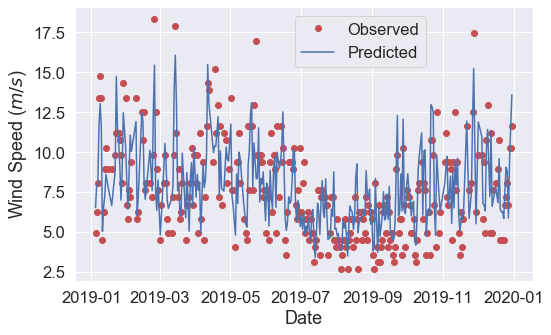

In [34]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_labels_wmax, 'ro', label = 'Observed')
ax.plot(test_dates, predictions_wmax, 'b-', label = 'Predicted')
# ax.plot(predictions, 'b-')
# ax.plot(test_labels, 'ro')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.savefig('./wmax_rf.png', dpi = 500)

### Total Precipitation

In [35]:
# New labels, features remain the same
train_labels_totalprecip = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_labels_totalprecip = np.array(features.query('year == 2019')['Daily Precip (mm)'])

In [36]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_totalprecip, new_features.query('year == 2019')['RTOT'].values)), 2), 'mm.')

Root Mean Square Error: 8.52 mm.


In [37]:
# Instantiate model
rfprecip = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)

## All columns, best parameters RMSE = 4.69mm
## Linear Reg best columns, best parameters RMSE = 4.66mm
## Linear Reg bester columns, best parameters RMSE = 4.42mm
## Linear Reg bester columns, best parameters, forcing predictions to be >=0 RMSE = 4.18mm

# Choose the columns we want to use in the regression!!!
column_names_totalprecip = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']
train_vars_totalprecip = new_features.query('year < 2019')[column_names_totalprecip] # Get the columns for training
test_vars_totalprecip = new_features.query('year == 2019')[column_names_totalprecip] # Get the columns for testing

# Train the model on training data
rfprecip.fit(train_vars_totalprecip, train_labels_totalprecip);

In [38]:
# Use the forest's predict method on the test data
predictions_totalprecip = rfprecip.predict(test_vars_totalprecip)
for i in np.arange(len(predictions_totalprecip)):
    if predictions_totalprecip[i] < 0:
        predictions_totalprecip[i] = 0.0

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels_totalprecip, predictions_totalprecip)), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


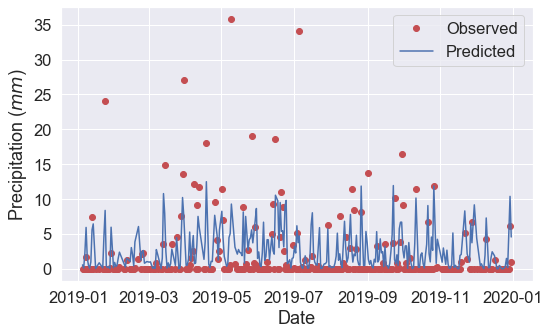

In [39]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_labels_totalprecip, 'ro', label = 'Observed')
ax.plot(test_dates, predictions_totalprecip, 'b-', label = 'Predicted')
# ax.plot(predictions, 'b-')
# ax.plot(test_labels, 'ro')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('./prcp_rf.png', dpi = 500)

In [40]:
# Get numerical feature importances
importances = list(rfprecip.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(column_names_totalprecip, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Min 500hPa DWPDEP(C) Importance: 0.14
Variable: Min 700hPa DWPDEP(C) Importance: 0.1
Variable: Avg PRES(hPa)        Importance: 0.09
Variable: Avg 700hPa DWPDEP(C) Importance: 0.08
Variable: Avg 850hPa DWPDEP(C) Importance: 0.07
Variable: Max HCLD(%)          Importance: 0.04
Variable: Min 850hPa DWPDEP(C) Importance: 0.04
Variable: Max 850hPa DWPDEP(C) Importance: 0.04
Variable: Avg 500hPa HGT(m)    Importance: 0.04
Variable: Avg 500hPa DWPDEP(C) Importance: 0.04
Variable: RTOT                 Importance: 0.03
Variable: tmpc                 Importance: 0.03
Variable: mslp                 Importance: 0.03
Variable: skct                 Importance: 0.03
Variable: Max MCLD(%)          Importance: 0.03
Variable: Avg 250hPa DWPDEP(C) Importance: 0.03
Variable: TMAX                 Importance: 0.02
Variable: TMIN                 Importance: 0.02
Variable: WMAX                 Importance: 0.02
Variable: Max 500hPa WSPD(m/s) Importance: 0.02
Variable: Max 925hPa WSPD(m/s) Importance